## 事前環境構築

```
$ sudo apt-get install -y python3
$ python3 -m venv ~/.venv
$ source ~/.venv/bin/activate
$ pip install jupyter tensorboard jupyter-tensorboard
$ jupyter notebook
```

In [ ]:
#環境構築 (jupyterは事前に実行)
# for keras-rl
!sudo apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install gym keras-rl

# tensorboard
# !pip install tensorflow tensorboard jupyter jupyter-tensorboard

# モデル可視化
!sudo apt-get -y install graphviz
!pip install pydot graphviz
# 学習曲線可視化
!pip install bokeh pandas

In [1]:
#環境設定
import numpy as np
import random

SEED=123
random.seed(SEED)
np.random.seed(SEED)

# OpenAI gym problem setting
#ENV_NAME = 'CartPole-v0'
ENV_NAME = 'MsPacman-v0'

# Atrariゲームは画面を直接入力にする
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

# 学習曲線保存ファイル
HIST_FILE = 'dqn_{}_history.csv'.format(ENV_NAME)
# モデルファイル
MODEL_FILE = 'dqn_model_{}.json'.format(ENV_NAME)
# 訓練済み評価値最大モデルパラメータファイル
BEST_WEIGHT_FILE = 'dqn_{}_best_weights.h5f'.format(ENV_NAME)
# 最後のモデルパラメータファイル
LAST_WEIGHT_FILE = 'dqn_{}_last_weights.h5f'.format(ENV_NAME)

In [4]:
#初期設定
import gym
from PIL import Image

from bokeh.io import push_notebook

from keras.callbacks import Callback, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.core import Processor
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

env = gym.make(ENV_NAME)
env.seed(SEED)
nb_actions = env.action_space.n

"""
Atari(Game) Processor
"""
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

    
"""
Keras Callback Stream Graph Updater
"""
class GraphUpdater(Callback):

    """
    @param target bokeh.io.show return object
    @param source bokeh.plotting.ColumnDataSource
    @param df pandas.DataFrame
    """
    def __init__(self, target, source, df):
        self.target = target
        self.source = source
        self.lastIndex = len(df.index)
    
    def on_epoch_end(self, epoch, logs={}):
        self.source.stream({'index':[self.lastIndex], 'epoch':[epoch], 'episode_reward':[logs.get('episode_reward')], 
                            'nb_episode_steps':[logs.get('nb_episode_steps')], 'nb_steps':[logs.get('nb_steps')]})
        self.lastIndex += 1
        push_notebook(handle=self.target)
        

def createDQNAgent(model):
    memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
    processor = AtariProcessor()
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

    dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
    dqn.compile(Adam(lr=.00025), metrics=['mae'])
    
    # avoid for CSVLogger Error
    dqn.stop_training = False
    
    return dqn


mc_cb = ModelCheckpoint(filepath=BEST_WEIGHT_FILE, monitor='episode_reward', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
mc_cb2 = ModelCheckpoint(filepath=LAST_WEIGHT_FILE, save_weights_only=True)
# file format: epoch, episord_reward, zero, epidoe step, total episode step
csv_cb = CSVLogger(HIST_FILE, separator=',', append=True)
callbacks = [mc_cb, mc_cb2, csv_cb]

In [5]:
# グラフ可視化 (stream)
from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import figure, ColumnDataSource
import os
import pandas as pd

if os.path.exists(HIST_FILE) :
    df = pd.read_csv(HIST_FILE)
else:
    df = pd.DataFrame({'epoch':[], 'episode_reward':[], 'nb_episode_steps':[], 'nb_steps':[]})

source = ColumnDataSource(df)
fig = figure(x_axis_type="linear",
             x_axis_label="epoch",
             y_axis_label="episode_reward",
             plot_width=800,
             plot_height=600)
fig.line(source=source, x='index', y='episode_reward')
output_notebook()
target = show(fig, notebook_handle=True)

callbacks.append(GraphUpdater(target, source, df))

Loading BokehJS ...

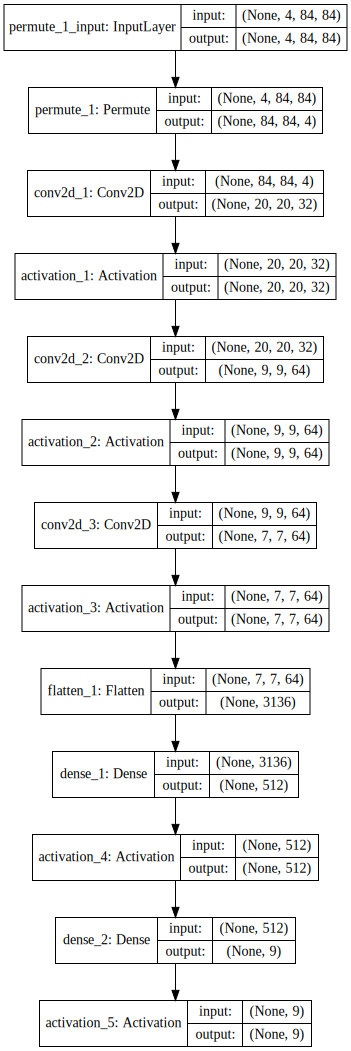

In [6]:
# モデル構造 (初回学習時)
import keras.backend as K

from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, Permute

# Next, we build our model. We use the same model that was described by Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()
if K.image_dim_ordering() == 'tf':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_dim_ordering() == 'th':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')
model.add(Conv2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
with open(MODEL_FILE, 'w') as f:
    f.write(model.to_json())

dqn = createDQNAgent(model)

# モデル構造可視化

# 簡易版
# print(model.summary())
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# モデル構造読み込み (学習途中再開時)
with open(MODEL_FILE.format(ENV_NAME)) as f:
    model = model_from_json(f.read())

dqn = createDQNAgent(model)
dqn.load_weights(LAST_WEIGHT_FILE)

In [7]:
# 学習スタート
hist = dqn.fit(env, nb_steps=10000, callbacks=callbacks, visualize=True, verbose=2)

Training for 10000 steps ...

Epoch 00001: episode_reward improved from -inf to 27.00000, saving model to dqn_MsPacman-v0_best_weights.h5f
  733/10000: episode: 1, duration: 14.908s, episode steps: 733, steps per second: 49, episode reward: 27.000, mean reward: 0.037 [0.000, 1.000], mean action: 4.027 [0.000, 8.000], mean observation: 59.370 [0.000, 171.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --

Epoch 00002: episode_reward improved from 27.00000 to 30.00000, saving model to dqn_MsPacman-v0_best_weights.h5f
 1518/10000: episode: 2, duration: 15.036s, episode steps: 785, steps per second: 52, episode reward: 30.000, mean reward: 0.038 [0.000, 1.000], mean action: 4.096 [0.000, 8.000], mean observation: 59.186 [0.000, 214.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --

Epoch 00003: episode_reward did not improve
 2065/10000: episode: 3, duration: 10.576s, episode steps: 547, steps per second: 52, episode reward: 12.000, mean reward: 0.022 [0.000,

In [ ]:
dqn.load_weights(LAST_WEIGHT_FILE)

In [8]:
dqn.load_weights(BEST_WEIGHT_FILE)

In [9]:
# test trained model
dqn.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
Episode 1: reward: 27.000, steps: 667
Episode 2: reward: 30.000, steps: 799
Episode 3: reward: 20.000, steps: 663
Episode 4: reward: 18.000, steps: 879
Episode 5: reward: 23.000, steps: 954


参考リンク
* http://matthewrocklin.com/blog/work/2017/10/16/streaming-dataframes-1
* http://elix-tech.github.io/ja/2016/06/29/dqn-ja.html
* https://qiita.com/panchovie/items/af9bac0e8ad8945bdf09
* http://tekenuko.hatenablog.com/entry/2017/07/25/005348
* http://www.procrasist.com/entry/jupyter-more-interactive

TODO
* Policyなど精度を上げるための方法を考える
* ドメイン知識として同じ場所に留まる、移動距離が少ない場合にペナルティを入れたい
* streamzでのファイル監視はうまくいかなかった